In [719]:
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor)
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    RandomizedSearchCV,
    KFold,
    train_test_split,
    GridSearchCV)
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from math import sqrt

In [865]:
class base:
    def __init__(self, **kwargs):
        self.features = kwargs["features"]
        self.response = kwargs["response"]

    def preProcess_features(self, **kwargs):
        if "rescale_type" not in kwargs.keys():
            standardized = preprocessing.StandardScaler()
            features_processed = standardized.fit_transform(np.array(self.features))
        elif kwargs["rescale_type"] == "norm":
            norm = preprocessing.MinMaxScaler()
            features_processed = norm.fit_transform(np.array(self.features))
        else:
            print(str(kwargs["rescale_type"])+ "rescaling technique not implemented \n Defaulting to standardized variables")
            standardized = preprocessing.StandardScaler()
            features_processed = standardized.fit_transform(np.array(self.features))

        self.features_processed = features_processed
        return features_processed

    def predict(self, **kwargs):
        features_to_predict = kwargs["features"]
        self.predictions = self.model.predict(features_to_predict)

    def run_CVs(self, **kwargs):

        standardized = preprocessing.StandardScaler()
        norm = preprocessing.MinMaxScaler()

        x_data = kwargs["features"]

        # Normalise or standardize, two different forms of rescaling
        if "rescale_type" not in kwargs.keys():
            x_data = standardized.fit_transform(np.array(x_data))
        elif kwargs["rescale_type"] == "norm":
            x_data = norm.fit_transform(np.array(x_data))
        else:
            print("rescaling technique not implemented \n Defaulting to standardized variables")
            x_data = standardized.fit_transform(np.array(x_data))

        y_data = np.array(kwargs["response"])
        n_folds = kwargs["n_folds"]
        title = kwargs["title"]

        kf = KFold(n_splits=n_folds)
        df = {}
        fold_indices = {}

        count = 1
        for train_index, test_index in kf.split(x_data):
            X_train, X_test = x_data[train_index], x_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]

            model_cv = kwargs["model_type"]
            model_cv.fit(X_train, y_train)

            fold = model_cv.predict(X_test)
            df[f"Pred{count}"] = fold
            df[f"Obs{count}"] = y_test

            fold_indices[f"Train{count}"] = train_index
            fold_indices[f"Test{count}"] = test_index

            count += 1

        fig = plt.figure(figsize=(20, 15))

        count = 1

        comb_cv_obs = []
        comb_cv_preds = []

        # Wether or not to visualise the cross validation
        try:
            visualize = kwargs["visualize"]
        except:
            visualize = None

        if visualize:
            for i in range(n_folds):
                print(i)
                print(f"23{count}")
                ax = fig.add_subplot(5,2,count)
                sns.regplot(x=df[f"Obs{count}"], y=df[f"Pred{count}"])
                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)
                ax.set_ylabel("Predicted")
                ax.set_xlabel("Observed")
                ax.set_title(f"Fold{count}")
                r_val, pval = spearmanr(df[f"Obs{count}"], df[f"Pred{count}"])
                r2_val = round(r_val ** 2, 2)
                x_cord, y_cord = max(df[f"Obs{count}"]) * 0.15, max(df[f"Pred{count}"])
                ax.annotate(f"$R^2 = {r2_val}$", (x_cord, y_cord))

                comb_cv_preds.extend(df[f"Pred{count}"])
                comb_cv_obs.extend(df[f"Obs{count}"])

                count += 1

            R, pVal = spearmanr(comb_cv_obs, comb_cv_preds)
            R2 = round(R ** 2, 2)

            fig.suptitle(f"{title} (Combined data $R^2$ = {R2})")
            plt.tight_layout()
            direc = os.getcwd()
            out_direc = f"{direc}"
            os.makedirs(out_direc, exist_ok=True)
            plt.savefig(f'{out_direc}/Fold_{title}.png')
            # plt.savefig(f'{out_direc}/Fold_{title}.svg')
            plt.show()

            fig2 = plt.figure(figsize=(12, 10))
            ax2 = fig2.add_subplot(111)
            sns.regplot(x=comb_cv_obs, y=comb_cv_preds, ax=ax2)
            ax2.spines["top"].set_visible(False)
            ax2.spines["right"].set_visible(False)
            ax2.set_title(title, pad=10)
            r, pval = spearmanr(comb_cv_obs, comb_cv_preds)
            r2 = round(r ** 2, 2)
            x_coord = max(comb_cv_obs) * 0.75
            y_coord = max(comb_cv_preds) * 0.99
            ax2.text(x_coord, y_coord, f"$R^2 = {round(r2,2)}$")
            ax2.set_xlabel("Observations", labelpad=20)
            ax2.set_ylabel("Predictions", labelpad=20)
            fig2.tight_layout()
            fig2.savefig(f'{out_direc}/{title}.png') 
            # fig2.savefig(f'{out_direc}/{title}.svg')

        return df, fold_indices

In [950]:
class LR(base):

    """ Linear Regression Model """

    def train_lr(self, **kwargs):
        model = LinearRegression()

        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=LinearRegression(),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
           visualize=kwargs["visualize"])

        return df, fold_indices


class RF(base):

    """" Random Forest Regression Model """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.features_processed = self.preProcess_features(rescale_type=kwargs.get("rescale_type"))


    def grid_search(self, **kwargs):
        n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
        max_features = [1, 2, 3, 4,5,6,7,8,9,10]
        max_depth = [int(x) for x in np.linspace(10, stop=100, num=11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [10, 15, 20]
        bootstrap = [True, False]
        random_grid = {
            "n_estimators": n_estimators,
            "max_features": max_features,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf,
            "bootstrap": bootstrap}
       
        rf = RandomForestRegressor()
       
        rf_random = RandomizedSearchCV(
            estimator=rf,
            param_distributions=random_grid,
            n_iter=100,
            cv=3,
            verbose=2,
            random_state=42,
            n_jobs=-1)
        rf_random.fit(self.features_processed, self.response)
        print(rf_random.best_params_)

        self.ran_params = rf_random.best_params_

    def train_rf(self, **kwargs):
        model = RandomForestRegressor(
            n_estimators=self.ran_params["n_estimators"],
            min_samples_leaf=self.ran_params["min_samples_leaf"],
            min_samples_split=self.ran_params["min_samples_split"],
            max_features=self.ran_params["max_features"],
            max_depth=self.ran_params["max_depth"],
            bootstrap=self.ran_params["bootstrap"])

        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=RandomForestRegressor(
                n_estimators=self.ran_params["n_estimators"],
                min_samples_leaf=self.ran_params["min_samples_leaf"],
                min_samples_split=self.ran_params["min_samples_split"],
                max_features=self.ran_params["max_features"],
                max_depth=self.ran_params["max_depth"],
                bootstrap=self.ran_params["bootstrap"]),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])

        return df, fold_indices

    def feature_importance(self, **kwargs):

        importances = self.model.feature_importances_
        self.feature_importance_std = np.std([tree.feature_importances_ for tree in self.model.estimators_], axis=0)
        return importances
    

    
    
class GB(base):

    """ Gradient Boosting Regression Model """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.features_processed = self.preProcess_features(rescale_type=kwargs.get("rescale_type"))

    def grid_search(self, **kwargs):

        n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
        max_features = [1,2,3,4,5,6,7,8,9,10]
        max_depth = [int(x) for x in np.linspace(10, stop=100, num=11)]
        max_depth.append(None)
        min_samples_split = [2, 5, 10]
        min_samples_leaf = [10, 15, 20]
        bootstrap = [True, False]  
        random_grid = {
            "n_estimators": n_estimators,
            "max_features": max_features,
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "min_samples_leaf": min_samples_leaf}

        gb = GradientBoostingRegressor()
        
        gb_random = RandomizedSearchCV(
            estimator=gb,
            param_distributions=random_grid,
            n_iter=100,
            cv=3,
            verbose=2,
            random_state=42,
            n_jobs=-1)  
        gb_random.fit(self.features_processed, self.response)

        self.ran_params = gb_random.best_params_

    def train_gb(self, **kwargs):
        self.grid_search()
        model = GradientBoostingRegressor(
            n_estimators=self.ran_params["n_estimators"],
            min_samples_leaf=self.ran_params["min_samples_leaf"],
            min_samples_split=self.ran_params["min_samples_split"],
            max_features=self.ran_params["max_features"],
            max_depth=self.ran_params["max_depth"])

        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=GradientBoostingRegressor(
                n_estimators=self.ran_params["n_estimators"],
                min_samples_leaf=self.ran_params["min_samples_leaf"],
                min_samples_split=self.ran_params["min_samples_split"],
                max_features=self.ran_params["max_features"],
                max_depth=self.ran_params["max_depth"]),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])

        return df, fold_indices


class PLSR(base):

    """ Partial Least Squares Regression Model """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.features_processed = self.preProcess_features(rescale_type=kwargs.get("rescale_type"))

    def optimum_ncomps(self, **kwargs):
        self.features = np.array(self.features)
        self.response = np.array(self.response)
        X_train, X_test, y_train, y_test = train_test_split(
            self.features,
            self.response,
            test_size=kwargs["test_size"],
            random_state=8675309)
        # Compute the validation error for each n_comp
        trait_plot = []
        for n_comp in range(1, self.features.shape[1]):
            # print(len(self.features))
            my_plsr = PLSRegression(n_components=n_comp, scale=True)
            my_plsr.fit(X_train, y_train)
            preds = my_plsr.predict(X_test)
            trait_rmse = sqrt(mean_squared_error(y_test, preds))
            trait_plot.append(trait_rmse)

        min_trait_index = trait_plot.index(min(trait_plot))

        self.min_rmse = min(trait_plot)
        self.ncomps_min_rsme = min_trait_index + 1

    def train_plsr(self):
        model = PLSRegression(n_components=self.ncomps_min_rsme, scale=True)
        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=PLSRegression(n_components=self.ncomps_min_rsme),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])
        return df, fold_indices


class SVM(base):

    """ Support Vector Regression """

    def train_svm(self):
        model = SVR(epsilon=2)
        model.fit(self.features_processed, self.response)
        self.model = model

    def run_CVs(self, **kwargs):
        df, fold_indices = super().run_CVs(
            model_type=SVR(epsilon=2),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])
        return df, fold_indices

    Lasso
    
class Ridgemodel(base):
    
    """ lasso regression """
    
    def __init__(self, features, response, **kwargs):
        super().__init__(features=features, response=response, **kwargs)
        self.features_processed = self.preProcess_features(rescale_type=kwargs.get("rescale_type"))
    
    def paramSearch(self, **kwargs):
        self.features = np.array(self.features)
        self.response = np.array(self.response)
        
        X_train, X_test, y_train, y_test = train_test_split(
            self.features,
            self.response,
            test_size=kwargs["test_size"],
            random_state=8675309)
        
        ridge=Ridge()
        
        alphas = np.logspace(-3, 2, 100) 
        param_grid = {'alpha':alphas}
        
        grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train, y_train)
        
        self.best_alpha = grid_search.best_params_['alpha']
    
    def run_CVs(self,**kwargs):
        df, fold_indices = super().run_CVs(
            model_type=Ridge(alpha=self.best_alpha),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])
        return df, fold_indices

class Lassomodel(base):
    
    """ lasso regression """
    
    def __init__(self, features, response, **kwargs):
        super().__init__(features=features, response=response, **kwargs)
        self.features_processed = self.preProcess_features(rescale_type=kwargs.get("rescale_type"))
    
    def paramSearch(self, **kwargs):
        self.features = np.array(self.features)
        self.response = np.array(self.response)
        
        X_train, X_test, y_train, y_test = train_test_split(
            self.features,
            self.response,
            test_size=kwargs["test_size"],
            random_state=8675309)
        
        ridge=Lasso()
        
        alphas = np.logspace(-3, 4, 1000)
        # print(alphas)
        param_grid = {'alpha':alphas}
        
        grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train, y_train)
        
        self.best_alpha = grid_search.best_params_['alpha']
    
    def run_CVs(self,**kwargs):
        df, fold_indices = super().run_CVs(
            model_type=Lasso(alpha=self.best_alpha,max_iter=100000),
            features=kwargs["features"],
            response=kwargs["response"],
            n_folds=kwargs["n_folds"],
            title=kwargs["title"],
            visualize=kwargs["visualize"])
        return df, fold_indices

In [1056]:
crawfordsville=pd.read_csv("Data/Crawfordsville/Satelliteimages/sixband/Sixband_Crawfordsville_TP6.csv", index_col=0)

In [1057]:
crawfordsville.columns

Index(['file_', 'Red_mean', 'Red_median', 'Red_sum', 'Green_mean',
       'Green_median', 'Green_sum', 'Blue_mean', 'Blue_median', 'Blue_sum',
       'GLI_mean', 'GLI_median', 'GLI_sum', 'NGRDI_mean', 'NGRDI_median',
       'NGRDI_sum', 'NDVI_mean', 'NDVI_median', 'NDVI_sum', 'NDRE_mean',
       'NDRE_median', 'NDRE_sum', 'RedEdge_mean', 'RedEdge_median',
       'RedEdge_sum', 'DeepBlue_mean', 'DeepBlue_median', 'DeepBlue_sum',
       'field', 'range', 'row', 'plantDensity', 'combineYield', 'yieldPerAcre',
       'totalStandCount', 'daysToAnthesis', 'GDDToAnthesis', 'daysToSilk',
       'GDDToSilk', 'percentMoisture', 'percentStarch', 'percentProtein',
       'percentOil', 'percentFiber', 'percentAsh', 'percentLodging',
       'flagLeafHeight', 'location', 'Timepoint', 'exp'],
      dtype='object')

In [1058]:
np.logspace(-4, 4, 10)

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [1059]:
crawfordsville=crawfordsville.iloc[:,list(range(1, 28))+[33]]
crawfordsville=crawfordsville.dropna()
feature=crawfordsville.iloc[:,list(range(0, 27))].values
response=crawfordsville.iloc[:,27].values

In [1046]:
# crawfordsville=crawfordsville.iloc[:,list(range(1, 16))+[21]]
# crawfordsville=crawfordsville.dropna()
# feature=crawfordsville.iloc[:,list(range(0, 15))].values
# response=crawfordsville.iloc[:,15].values

In [1047]:
crawfordsville.columns

Index(['Red_mean', 'Red_median', 'Red_sum', 'Green_mean', 'Green_median',
       'Green_sum', 'Blue_mean', 'Blue_median', 'Blue_sum', 'GLI_mean',
       'GLI_median', 'GLI_sum', 'NGRDI_mean', 'NGRDI_median', 'NGRDI_sum',
       'yieldPerAcre'],
      dtype='object')

In [1048]:
# model=RF(response=response,features=feature,rescale_type="norm")
# model.grid_search()
# results,nfolds=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldRFUAV-TP3")

In [1061]:
# model=LR(response=response,features=feature,rescale_type="norm")
# results, nfold=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldSatelliteLRsixband-TP6")

In [1050]:
# model=SVM(response=response,features=feature,rescale_type="norm")
# results, nfold=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldSVMSatellitesixband-TP6")

In [1051]:
# model=GB(response=response,features=feature,rescale_type="norm")
# model.grid_search()
# results, nfold=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldGBuav-TP3")

In [1052]:
# model=PLSR(response=response,features=feature,rescale_type="norm")
# model.optimum_ncomps(test_size=10)
# results, nfold=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldLPLSRSatellitesixband-TP6")

In [1053]:
# model=Ridgemodel(response=response,features=feature,rescale_type="norm")
# model.paramSearch(test_size=10)
# results, nfold=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldRidgeuav-TP3")

In [1062]:
# model=Lassomodel(response=response,features=feature,rescale_type="norm")
# model.paramSearch(test_size=10)
# results, nfold=model.run_CVs(response=response,features=feature,n_folds=10,visualize=True,title="10FoldLassouav-TP3")

In [1063]:
df=pd.read_excel("ModelPerformance.xlsx")

In [1064]:
df

,location,timepoint,model,image,r2
0,crawfordsville,TP1,GB,satellite,0.09
1,crawfordsville,TP2,GB,satellite,0.08
2,crawfordsville,TP3,GB,satellite,0.14
3,crawfordsville,TP4,GB,satellite,0.08
4,crawfordsville,TP5,GB,satellite,0.01
5,crawfordsville,TP6,GB,satellite,0.07
6,crawfordsville,TP1,GB,uav,0.09
7,crawfordsville,TP2,GB,uav,0.01
8,crawfordsville,TP3,GB,uav,0.11
9,crawfordsville,TP1,PLSR,satellite,0.07


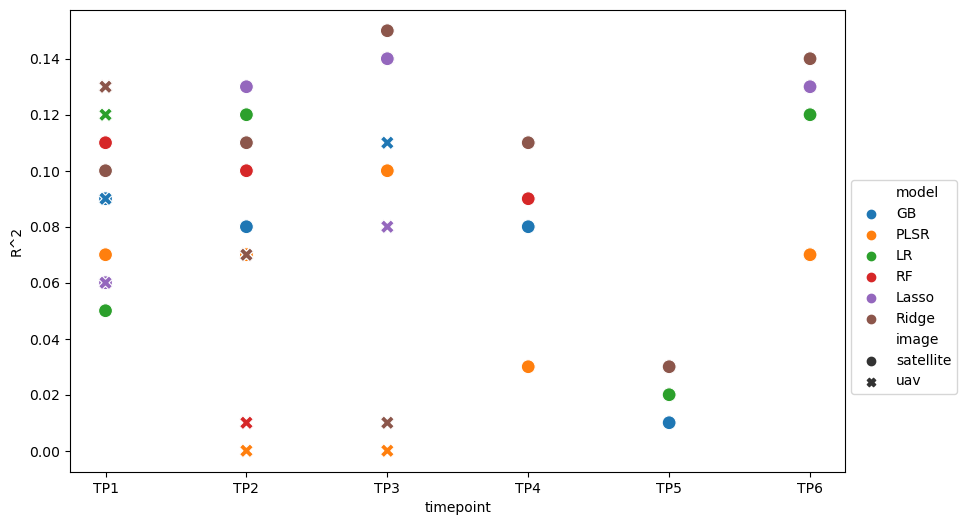

In [1077]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['timepoint'],y=df['r2'],hue=df["model"],style=df["image"],s=100)
plt.legend(loc='center left',bbox_to_anchor=(0.999, 0.4))
plt.ylabel('R^2')
plt.savefig("Modelcomparison.png")